<a href="https://colab.research.google.com/github/Jeongho-K/Car-model-classification/blob/main/code/2_Car_classification_with_efficient_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글폰트 설치(런타임 재실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# 한글폰트 지정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 차량 이미지 데이터 준비

data: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=554

## 차량 방향 확인을 위한(for yolov4) 이미지 리스트 생성

In [ ]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import glob

In [ ]:
def make_img_list(BASE_FOLDER, OUTPUT):
    f_list = []
    for model_name in os.listdir(BASE_FOLDER):
        model_path = os.path.join(BASE_FOLDER, model_name)
        for detail_forder in os.listdir(model_path):
            folder_path = os.path.join(model_path, detail_forder + '/*')
            f_list += glob.glob(folder_path)

    with open(OUTPUT, 'w', encoding="UTF8") as f:
        for line in f_list:
            f.write(line)
            f.write('\n')

In [ ]:
train_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/1.Training/원천데이터/HY_현대"
train_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/train_image_list.txt'

make_img_list(train_BASE_FOLDER, train_OUTPUT)

In [ ]:
val_BASE_FOLDER = r"/content/drive/MyDrive/Car-model-classification/data/2.Validation/원천데이터/HY_현대"
val_OUTPUT = '/content/drive/MyDrive/Car-model-classification/data/val_image_list.txt'

make_img_list(val_BASE_FOLDER, val_OUTPUT)

## yolov4 custom(차량 앞, 뒤, 옆 분류)

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.17 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (10405/10405), done.


- darknet모델내 makefile파일 내용 수정  
- GPU=1, CUDNN=1, OPENCV=1

In [ ]:
import os
path = '/content/darknet'
os.chdir(path)
!make

In [ ]:
# verify installation
!./darknet

usage: ./darknet <function>


In [ ]:
# pretrained weights
import shutil
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car.cfg', 'cfg/yolov4-car.cfg')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/yolov4-car_best.weights', 'cfg/yolov4-car_best.weights')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.names', 'data/car.names')
shutil.copy('/content/drive/MyDrive/Car-model-classification/models/YOLOv4_사전학습/car.data', 'data/car.data')

'data/car.data'

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/train_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/train_image_list.txt

In [ ]:
!./darknet detector test data/car.data cfg/yolov4-car.cfg cfg/yolov4-car_best.weights -dont_show -out /content/drive/MyDrive/Car-model-classification/data/val_direction_results.json < /content/drive/MyDrive/Car-model-classification/data/val_image_list.txt

### 차량 front, side, back label
yolo모델로 생성된 direction_results.json으로 방향 class별 3개 라벨 데이터 생성

## 이미지 crop 후 방향에 맞춰 이미지 저장

In [31]:
import os
import json
import cv2
import numpy as np
import shutil

In [32]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [33]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

In [34]:
def check_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [35]:
# box 정보에 대해 margin 값만큼 확장함
def expand_box(box, margin, img_width = None, img_height = None):
    x = box["left"]
    y = box["top"]
    w = box["width"]
    h = box["height"]

    x = x - margin
    x = max(x, 0)
    y = y - margin
    y = max(y, 0)

    w = w + 2*margin
    if img_width and x + w > img_width:
        w = img_width - x
    
    h = h + 2*margin
    if img_height and y + h > img_height:
        h = img_height - y

    new_box = {
        "left": x, 
        "top": y,
        "width": w,
        "height": h
    }

    return new_box

In [36]:
# 이미지 crop
def crop_image(image_np, box, margin = 0):
    if margin > 0:
        box = expand_box(box, margin)
       
    x1 = box["left"]
    y1 = box["top"]
    x2 = box["left"] + box["width"]
    y2 = box["top"] + box["height"]
    return image_np[y1:y2, x1:x2]

In [37]:
# 한글 경로 지원
def imread( file_path ) :
    stream = open( file_path.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    np_array = np.asarray(bytes, dtype=np.uint8)
    return cv2.imdecode(np_array , cv2.IMREAD_UNCHANGED)

In [38]:
# 한글 경로 지원
def imwrite(file_path, img, params=None):
    try: 
        ext = os.path.splitext(file_path)[1]
        result, n = cv2.imencode(ext, img, params)
        if result: 
            with open(file_path, mode='w+b') as f:
                n.tofile(f)
                return True
        else: 
            return False 
    except Exception as e: 
        print(e)
        return False

In [39]:
# 전체 이미지 bbox가 있는 경우 crop하고 아닌경우는 그냥 방향정보에 따라 저장 
def crop_store_by_direction(direction_path, BASE_OUTPUT_FOLDER):
    dir_json = load_json(direction_path)

    for dir in dir_json:

        if len(dir['objects']) > 0:
            confidence = [x['confidence'] for x in dir['objects']]
            best_idx = confidence.index(max(confidence)) # 가장 신뢰도 높은 분류 class

            img_path = dir['filename']
            tmp_list = img_path.split('/')
            tmp_list[7] = '라벨링데이터'
            img_name = tmp_list[11]
            json_name = img_name.split('.')[0] + '.json'
            json_path = '/'.join(tmp_list[:-1]) + '/' + json_name

            img_json = load_json(json_path)
            object_list = img_json["learningDataInfo"]["objects"]
            
            for i in range(len(object_list)):
                img = imread(img_path) # 이미지 로드
                if img_json["learningDataInfo"]["objects"][i]["classId"] == 'P00.차량전체':
                    # 차량 전체 bbox
                    box = {
                            "left": int(img_json["learningDataInfo"]["objects"][i]["left"]),
                            "top": int(img_json["learningDataInfo"]["objects"][i]["top"]),
                            "width": int(img_json["learningDataInfo"]["objects"][i]["width"]),
                            "height": int(img_json["learningDataInfo"]["objects"][i]["height"])
                            }

                    # 이미지 크롭
                    img = crop_image(img, box, 10)

                # 방향 확인 후 해당 폴더에 저장
                direction = dir['objects'][best_idx]['name']
                output_folder = os.path.join(BASE_OUTPUT_FOLDER, direction)
                check_folder(output_folder)
                output_path = os.path.join(output_folder, str(img_name))

                imwrite(output_path, img) # 이미지 저장

                # 라벨링 데이터도 같이 이동
                shutil.copyfile(json_path, os.path.join(output_folder, str(json_name)))

        print(dir['frame_id'])

In [ ]:
# train & validation img
train_val_direction_path = '/content/drive/MyDrive/Car-model-classification/data/train_direction_results.json'
train_val_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/train_val'

crop_store_by_direction(train_val_direction_path, train_val_output_folder)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283
16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343
16344
16345
16346
1634

In [ ]:
# test img
test_direction_path = '/content/drive/MyDrive/Car-model-classification/data/val_direction_results.json'
test_output_folder = '/content/drive/MyDrive/Car-model-classification/data/cropimg/test'

crop_store_by_direction(test_direction_path, test_output_folder)

# 차량 분류 모델 학습전 import, 데이터 준비

## image dastaframe

In [ ]:
import pandas as pd
import json
import os

In [17]:
# 텍스트 읽기
def read_text(file_path, encoding="utf-8"):
    text = None
    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()
    return text

In [18]:
def load_json(json_path, encoding="utf-8"):
    return json.loads(read_text(json_path, encoding))

### setup image dataframe

In [24]:
def make_df(dataset_path, direction):
    base_path = os.path.join(dataset_path, direction)
    img_path = []
    brand = []
    model_year = []
    for files in os.listdir(base_path):
        if os.path.splitext(files)[1] == '.json':
            tmp_json = load_json(os.path.join(base_path, files))
            img_path.append(os.path.join(base_path, tmp_json['sourceDataInfo']['sourceDataID']+'.jpg'))
            brand.append(tmp_json['rawDataInfo']['MediumCategoryId'])
            model_year.append(tmp_json['rawDataInfo']['SmallCategoryId']+'_'+str(tmp_json['rawDataInfo']['yearId']))

    data = {
        'img_path':img_path,
        'brand':brand,
        'model_year':model_year
    }
    df = pd.DataFrame(data)
    return df

In [20]:
base_dir = '/content/drive/MyDrive/Car-model-classification/data/cropimg'
train_val_dir = os.path.join(base_dir, 'train_val')
test_dir = os.path.join(base_dir, 'test')

In [23]:
# Setup the front Image df
train_val_front_df = make_df(train_val_dir, 'car_front')
test_front_df = make_df(test_dir, 'car_front')

# Setup the side Image df
train_val_side_df = make_df(train_val_dir, 'car_side')
test_side_df = make_df(test_dir, 'car_side')

# Setup the back Image df
train_val_back_df = make_df(train_val_dir, 'car_back')
test_back_df = make_df(test_dir, 'car_back')

FileNotFoundError: ignored

### split train, validation dataframe

In [ ]:
# 각 차량 모델별 20%를 추출해 val_df로
def split_df(train_val_df):
    val_df = pd.DataFrame()
    for model_year in list(train_val_df['model_year'].unique()):
        sample_df = train_val_df[train_val_df['model_year'] == model_year].sample(frac=0.2)
        val_df = pd.concat([val_df, sample_df], ignore_index=True)

    train_df = pd.concat([train_val_df, val_df, val_df]).drop_duplicates(keep=False).reset_index()
    return train_df, val_df

In [ ]:
# split train, val
train_front_df, val_front_df = split_df(train_val_front_df)
train_side_df, val_side_df = split_df(train_val_side_df)
train_back_df, val_back_df = split_df(train_val_back_df)

In [ ]:
print(len(train_front_df))
print(len(val_front_df))
print(len(test_front_df))
print()

print(len(train_side_df))
print(len(val_side_df))
print(len(test_side_df))
print()

print(len(train_back_df))
print(len(val_back_df))
print(len(test_back_df))

5539
1384
830

5051
1263
836

4882
1220
792


In [29]:
def check_class(df):
    print(len(df['model_year'].unique()))
    print(df['model_year'].value_counts())
    print()

In [ ]:
check_class(train_front_df)
check_class(val_front_df)
check_class(test_front_df)

그랜저      714
쏘나타      703
아반떼      692
코나       580
싼타페      561
투싼       426
스타렉스     333
포터2      284
팰리세이드    246
아이오닉     228
엑센트      195
베뉴       163
i30      160
벨로스터     156
맥스크루즈     88
넥쏘        10
Name: model, dtype: int64

In [ ]:
check_class(train_side_df)
check_class(val_side_df)
check_class(test_side_df)

그랜저      178
쏘나타      176
아반떼      173
코나       145
싼타페      140
투싼       107
스타렉스      83
포터2       71
팰리세이드     61
아이오닉      57
엑센트       49
베뉴        41
i30       40
벨로스터      39
맥스크루즈     22
넥쏘         2
Name: model, dtype: int64

In [ ]:
check_class(train_back_df)
check_class(val_back_df)
check_class(test_back_df)

쏘나타      107
아반떼      101
그랜저       92
코나        83
싼타페       78
투싼        73
스타렉스      63
포터2       38
팰리세이드     34
아이오닉      31
i30       29
엑센트       28
벨로스터      26
베뉴        24
맥스크루즈     20
넥쏘         3
Name: model, dtype: int64

## Imports

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def generate_dataset(train_df, val_df, test_df):
    '''
    image dataset 생성
    ImageDataGenerator  
    * rotation_range : 이미지회전값  
    * zoom_range : 이미지일부확대  
    * shear_range : 이미지기울기  
    * width_shift_range : 좌우이동  
    * height_shift_range : 상하이동  
    * horizontal_flip : 이미지가로뒤집기  
    * vertical_filp : 이미지세로뒤집기
    '''
    train_generator = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    fill_mode='nearest')

    test_generator = ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='img_path',
        y_col='model',
        target_size=(width,height),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_images, val_images, test_images

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_hist(hist, value):
    '''
    모델 학습 결과 확인 Plot
    '''
    plt.plot(hist.history[f"{value}"])
    plt.plot(hist.history[f"val_{value}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def plot_heatmap(model, image_set, class_num):
    '''
    plot haetmap
    '''
    predictions = np.argmax(model.predict(test_front_images), axis=1)

    cm = confusion_matrix(image_set.labels, predictions)

    plt.figure(figsize=(30, 30))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(class_num) + 0.5, labels=image_set.class_indices, rotation=90)
    plt.yticks(ticks=np.arange(class_num) + 0.5, labels=image_set.class_indices, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 224 x 224
        features (array) -- features of the image, shape (1, 7, 7, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (224,224))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

# efficientnetv2B0 vs efficientnetv2S
front image만 비교  
결과 efficientnetv2S 모델 선택

## efficientnetv2B0 car front images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
class_num = 49
batch_size = 32

width = 224
height = 224
epochs = 40
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)

Found 5539 validated image filenames belonging to 16 classes.
Found 1384 validated image filenames belonging to 16 classes.
Found 830 validated image filenames belonging to 16 classes.
Found 5051 validated image filenames belonging to 16 classes.
Found 1263 validated image filenames belonging to 16 classes.
Found 836 validated image filenames belonging to 16 classes.
Found 4882 validated image filenames belonging to 16 classes.
Found 1220 validated image filenames belonging to 16 classes.
Found 792 validated image filenames belonging to 16 classes.


### load the conv base model (efficientNetV2B0)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2B0(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalMaxPooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(class_num, activation='softmax', name="fc_out")

efnv2b0_model = tf.keras.Model(inputs, outputs)

In [ ]:
efnv2b0_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 10, 10, 1536)     10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 16)                24592     
                                                                 
Total params: 10,808,120
Trainable params: 10,720,824
Non-trainable params: 87,296
_________________________________________________________________


In [ ]:
efnv2b0_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2b0_car_front_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2b0_model.fit_generator(
    train_front_images,
    epochs=epochs,
    validation_data=val_front_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-36-d72cd81b4f58>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
 15/174 [=>............................] - ETA: 24:28 - loss: 12.1142 - acc: 0.0812

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored

### Results

#### plot accuracy & loss

In [ ]:
plot_hist(history, 'accuracy')
plot_hist(history, 'loss')

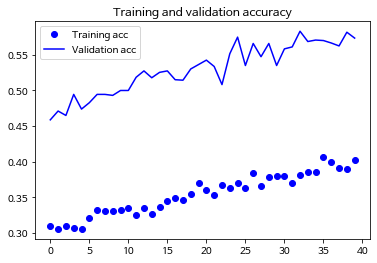

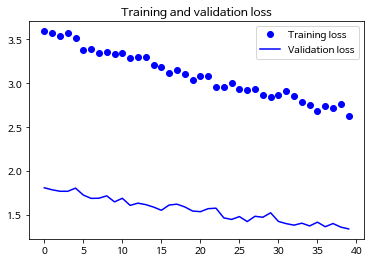

In [ ]:
# 학습 결과
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2b0_model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 57.58%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

In [ ]:
plot_heatmap(efnv2b0_model, test_front_images, class_num)

#### Class Activation Map(CAM)

In [ ]:
for img, lbl in test_front_images.take(5):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features,results = efnv2b0_model.predict(img)
    show_cam(img, features, results, lbl)

## efficientnetv2S car front images

### Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
class_num = 49
batch_size = 32

width = 384
height = 384
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

### image dataset

In [ ]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)

Found 5830 validated image filenames belonging to 16 classes.
Found 1459 validated image filenames belonging to 16 classes.
Found 877 validated image filenames belonging to 16 classes.
Found 5336 validated image filenames belonging to 16 classes.
Found 1335 validated image filenames belonging to 16 classes.
Found 887 validated image filenames belonging to 16 classes.
Found 5116 validated image filenames belonging to 16 classes.
Found 1277 validated image filenames belonging to 16 classes.
Found 835 validated image filenames belonging to 16 classes.


### load the conv base model (efficientNetV2S)

In [ ]:
inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.applications.EfficientNetV2S(include_top = False, weights = 'imagenet')(inputs)
x = layers.GlobalMaxPooling2D(name="gap")(x)
x = layers.Dropout(dropout_rate, name="dropout_out")(x)
outputs = layers.Dense(class_num, activation='softmax', name="fc_out")

efnv2S_model = tf.keras.Model(inputs, outputs)

In [ ]:
efnv2S_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 10, 10, 1536)     10783528  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1536)              0         
                                                                 
 dropout_out (Dropout)       (None, 1536)              0         
                                                                 
 fc_out (Dense)              (None, 16)                24592     
                                                                 
Total params: 10,808,120
Trainable params: 24,592
Non-trainable params: 10,783,528
_________________________________________________________________


In [ ]:
efnv2S_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

model_name = '/content/drive/MyDrive/Car-model-classification/models/efnv2S_car_front_model.h5'
checkpoint_cb = ModelCheckpoint(model_name, save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efnv2S_model.fit_generator(
    train_front_images,
    epochs=epochs,
    validation_data=val_front_images,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cb, early_stopping_cb, PlotLearning()]
)

<ipython-input-64-e0fce14d5953>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/60
 90/183 [=============>................] - ETA: 1:25 - loss: 10.8241 - acc: 0.0519

### Results

#### plot accuracy & loss

In [ ]:
plot_hist(history, 'accuracy')
plot_hist(history, 'loss')

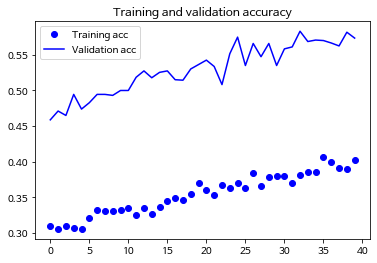

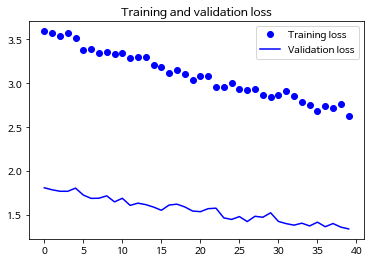

In [ ]:
# 학습 결과
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### test accuracy

In [ ]:
# test image set 결과
results = efnv2S_model.evaluate(test_front_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 57.58%


#### Heatmap
실제 label과 해당 사진을 모델이 예측한 결과

In [ ]:
plot_heatmap(efnv2b0_model, test_front_images, class_num)

#### Class Activation Map(CAM)

In [ ]:
for img, lbl in test_front_images.take(5):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features,results = efnv2b0_model.predict(img)
    show_cam(img, features, results, lbl)

# car front, side, back(efficientnetv2S)

## Hyper parameters

https://pypi.org/project/keras-efficientnet-v2/

In [ ]:
class_num = 49
batch_size = 32

width = 384
height = 384
epochs = 30
dropout_rate = 0.2
input_shape = (height, width, 3)

## image dataset

In [ ]:
train_front_images, val_front_images, test_front_images = generate_dataset(train_front_df, val_front_df, test_front_df)
train_side_images, val_side_images, test_side_images = generate_dataset(train_side_df, val_side_df, test_side_df)
train_back_images, val_back_images, test_back_images = generate_dataset(train_back_df, val_back_df, test_back_df)

Found 5830 validated image filenames belonging to 16 classes.
Found 1459 validated image filenames belonging to 16 classes.
Found 877 validated image filenames belonging to 16 classes.
Found 5336 validated image filenames belonging to 16 classes.
Found 1335 validated image filenames belonging to 16 classes.
Found 887 validated image filenames belonging to 16 classes.
Found 5116 validated image filenames belonging to 16 classes.
Found 1277 validated image filenames belonging to 16 classes.
Found 835 validated image filenames belonging to 16 classes.


# 데이터 셋내 잘못 분류된 이미지 제거 후 모델 결과